# PREPROCESSING

In [1]:
import cv2
import numpy as np

def preprocess(image):
    image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image_np, (640, 640))
    return image_resized

# OBJECT DETECTION MODEL

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [3]:
from ultralytics import YOLO

model = YOLO("/kaggle/input/large_bbox_model/other/default/1/best_large_bbox.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
def process_model(image):
    image_resized = preprocess(image)
    results = model(image_resized)[0]  # Ambil hasil pertama
    boxes = results.boxes  # Bounding box predictions

    bboxes = boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    classes = boxes.cls.cpu().numpy().astype(int)  # Class index (int)

    # print(f"class: {classes}")
    # print(f"BOX: {bboxes}")
    
    return bboxes, classes

# EASYOCR

In [5]:
label_map = {
    0: 'table',
    1: 'not_table'
}

In [6]:
import re
from typing import List

def split_detected_text(detected_text: str) -> List[str]:
    """
    Memecah string panjang hasil OCR menjadi list baris berdasarkan pola 'text price'
    Misalnya: "nasi campur 75,ooo ayam 60,ooo" → ["nasi campur 75,ooo", "ayam 60,ooo"]
    """
    # Ganti karakter OCR typo
    detected_text = detected_text.replace('o', '0').replace('O', '0').replace('q', '0')

    # Cari semua potongan yang diakhiri angka (misal 75,000 / 60.000 / 30.0)
    # Asumsikan bahwa item akan memiliki angka di akhir
    pattern = re.compile(r'(.*?\d[\d.,]*)(?=\s+[a-zA-Z]|$)')
    lines = pattern.findall(detected_text)

    # Bersihkan trailing whitespaces
    lines = [line.strip() for line in lines if line.strip()]
    return lines

In [7]:
import easyocr
import numpy as np
import cv2
import os

# Inisialisasi
keywords = ['total', 'amount', 'jumlah']
reader = easyocr.Reader(['en', 'id'])  # OCR untuk bahasa Inggris & Indonesia

# Tentukan folder untuk menyimpan hasil crop
output_folder = "cropped_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)  # Membuat folder jika belum ada

def crop_image_by_bbox(image: np.ndarray, bbox: list, save_path: str) -> np.ndarray:
    height, width = image.shape[:2]

    # Jika bbox terdiri dari 4 titik (persegi panjang), crop langsung
    if len(bbox) == 4:
        x_min, y_min, x_max, y_max = bbox
        # Validasi agar koordinat tidak keluar dari batas gambar
        x_min = int(max(0, min(x_min, width - 1)))
        x_max = int(max(0, min(x_max, width - 1)))
        y_min = int(max(0, min(y_min, height - 1)))
        y_max = int(max(0, min(y_max, height - 1)))

        # Crop gambar dengan menggunakan bounding box yang sudah divalidasi
        cropped_image = image[y_min:y_max, x_min:x_max]
        cv2.imwrite(save_path, cropped_image)  # Simpan gambar yang di-crop
        return cropped_image

    # Jika bbox terdiri dari 8 titik (quadrilateral), crop dengan perspektif
    elif len(bbox) == 8:
        # Quadrilateral: [x1, y1, x2, y2, x3, y3, x4, y4]
        pts = np.array(bbox, dtype=np.float32).reshape(-1, 2)

        # Tentukan koordinat tujuan untuk perspektif (tapi bisa disesuaikan sesuai kebutuhan)
        width = 640  # Misal ukuran output yang diinginkan
        height = 640
        dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

        # Dapatkan matriks perspektif
        matrix = cv2.getPerspectiveTransform(pts, dst_pts)

        # Terapkan transformasi perspektif untuk crop area sesuai bbox
        cropped_image = cv2.warpPerspective(image, matrix, (width, height))
        cv2.imwrite(save_path, cropped_image)  # Simpan gambar yang di-crop
        return cropped_image

    else:
        raise ValueError("Format bbox tidak valid.")

    
# Fungsi utama untuk membaca dan memproses gambar
def read_image(image):
    preprocessed = preprocess(image)  # Preprocess gambar sekali saja

    # Deteksi bbox dan kelas dari model (misalnya YOLO atau model deteksi objek lainnya)
    boxes, classes = process_model(preprocessed)

    print("Langsung cek keyword dari OCR global...")

    # OCR global seluruh gambar (mengembalikan per baris)
    ocr_result = reader.readtext(image)
    detected_lines = [text for _, text, _ in ocr_result]
    detected_text_lower = " ".join([t.lower() for t in detected_lines])

    # Cek apakah ada keyword di teks hasil OCR
    if any(keyword in detected_text_lower for keyword in keywords):
        print("Keyword ditemukan. Proses ekstraksi data receipt...")

        #OCR berdasarkan bbox dari hasil deteksi model
        detected_lines = []
        
        for idx, bbox in enumerate(boxes):
            try:
                save_path = os.path.join(output_folder, f"cropped_{idx}.jpg")
                cropped_image = crop_image_by_bbox(preprocessed, bbox, save_path)
                ocr_result = reader.readtext(cropped_image)
        
                # Ambil teks saja dari hasil OCR
                detected_lines.extend([text for _, text, _ in ocr_result])
        
            except ValueError as e:
                print(f"Error dalam cropping gambar: {e}")
                continue

        detected_text_lower = " ".join([t.lower() for t in detected_lines])
        print(detected_text_lower)
        
        lines = [clean_ocr_text(l) for l in split_detected_text(detected_text_lower)]
        ner_results = detect_class(lines)
        final_result = process_receipt_data_with_ner(ner_results)

        return final_result

    print("Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.")
    return {
        "status": "not_receipt_invoice",
        "error_msg": "Gambar yang Anda masukkan bukan receipt/invoice."
    }


In [8]:
# import spacy
# import re
# from typing import List, Dict, Union
# import re

# # Load spaCy NER model
# # nlp = spacy.load("/kaggle/input/ner_receipt_model/other/default/1")


# def preprocess_currency(text):
#     """Coba mengkonversi string yang terlihat seperti currency ke float, memperbaiki typo seperti 'ooo' jadi '000'"""
#     if not isinstance(text, str):
#         text = str(text)

#     # Ganti huruf o atau O dengan angka 0
#     text = text.replace('o', '0').replace('O', '0')

#     # Hanya pertahankan digit, titik dan koma
#     cleaned = re.sub(r'[^\d.,]', '', text)
#     cleaned = cleaned.replace(',', '')  # Hapus koma pemisah ribuan

#     try:
#         return float(cleaned)
#     except ValueError:
#         return None

In [9]:
# def spacy_ner_classification(lines: List[str]) -> List[Dict[str, Union[str, float]]]:
#     processed_results = []

#     for line in lines:
#         # Jalankan spaCy NER
#         doc = nlp(line)
        
#         # Cek apakah entitas ada
#         if doc.ents:
#             for ent in doc.ents:
#                 text = ent.text
#                 label = ent.label_.lower()  # ITEM, QUANTITY, PRICE → item, quantity, price
#                 result = {
#                     'class': label,
#                     'text': text
#                 }
#                 print(f"hasil nlp: {result}")

#                 # Kalau entitasnya PRICE, coba ekstrak angka float
#                 if label == 'price':
#                     numeric = preprocess_currency(text)
#                     if numeric is not None:
#                         result['numeric_value'] = numeric

#                 processed_results.append(result)
#         else:
#             # Jika tidak ada entitas, masukkan sebagai 'other' atau bisa di-skip
#             processed_results.append({
#                 'class': 'other',
#                 'text': line
#             })

#     return processed_results

In [10]:
import re
from typing import List, Dict, Union

def extract_price_from_line(line: str) -> Union[Dict[str, Union[str, int]], None]:
    """
    Ekstrak harga dari akhir baris teks dan konversi ke angka bulat (contoh: '75,ooo' jadi 75000)
    """
    # Bersihkan teks OCR-like typo: ooo → 000
    clean_line = line.replace("o", "0").replace("O", "0")
    
    # Deteksi harga (angka di akhir)
    match = re.search(r'(\d{1,3}(?:[.,]\d{3})*[.,]?\d*)\s*$', clean_line)
    
    if match:
        price_str = match.group(1)

        # Hapus semua koma/titik untuk dapatkan angka utuh
        price_digits_only = re.sub(r'[.,]', '', price_str)
        
        try:
            price = int(price_digits_only)
        except ValueError:
            return None

        item_name = clean_line[:match.start()].strip()
        return {
            'item': item_name,
            'price': price
        }
    
    return None

def clean_ocr_text(line: str) -> str:
    # Gabungkan angka yang terpisah spasi: "10 0o0" -> "10000"
    line = re.sub(r'(\d)\s+(\d)', r'\1\2', line)

    # Ganti huruf 'o' atau 'O' yang tertulis sebagai nol
    line = line.replace('o', '0').replace('O', '0')

    return line

def detect_class(lines: List[str]) -> List[Dict]:
    processed_results = []
    
    for line in lines:
        result = extract_price_from_line(line)
        if result:
            processed_results.append({
                'class': 'item',
                'text': result['item']
            })
            processed_results.append({
                'class': 'price',
                'price': result['price']
            })
        else:
            processed_results.append({
                'class': 'item',
                'text': line
            })
    
    return processed_results


In [11]:
import re
from typing import List, Dict, Union

def reconstruct_items(ner_results: List[Dict]) -> List[Dict]:
    """Mengelompokkan hasil NER yang terpisah menjadi item utuh"""
    reconstructed = []
    current_item = []
    last_was_item = False
    
    for entry in ner_results:
        if entry['class'] == 'item':
            if not last_was_item and current_item:
                # Jika bertemu item baru, selesaikan item sebelumnya
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            current_item.append(entry['text'])
            last_was_item = True
        else:
            if current_item:
                # Selesaikan item yang sedang dibangun
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            reconstructed.append(entry)  # Tambahkan price/entitas lain
            last_was_item = False
    
    # Tambahkan sisa item jika ada
    if current_item:
        reconstructed.append({
            'class': 'item',
            'text': ' '.join(current_item).strip(),
            'original_parts': current_item.copy()
        })
    
    return reconstructed

def pair_entities(ner_results: List[Dict]) -> List[Dict]:
    """Memasangkan item dan price yang berurutan"""
    paired = []
    i = 0
    n = len(ner_results)
    
    while i < n:
        if ner_results[i]['class'] == 'item':
            item = ner_results[i]['text']
            price = None
            numeric_price = None

            # Cari price berikutnya
            if i + 1 < n and ner_results[i+1]['class'] == 'price':
                price_entry = ner_results[i+1]
                price = price_entry.get('price')  # Akses 'price' jika sudah diganti
                numeric_price = price_entry.get('price')  # Atau akses langsung numeric value

                i += 1  # Lewati price yang sudah diproses
            
            paired.append({
                'item_name': item,
                'price': numeric_price
            })
        i += 1
    
    return paired


def is_noise(text: str) -> bool:
    """
    Mengecek apakah suatu teks termasuk 'noise' (bukan item menu, misalnya total, service, dll)
    """
    noise_keywords = [
        'subtotal', 'sub total', 'service', 'tax', 'pajak', 'pb1', 't0tal', 'subt0tal',
        'r0unding','disk0n','disc0unt',
        'rounding', 'diskon', 'discount', 'total', 'grand total', 'change', 'kembalian', 'srand tl'
    ]
    text = text.lower()
    return any(keyword in text for keyword in noise_keywords)


def process_receipt_data_with_ner(ner_results: List[Dict]) -> Dict:
    """Pipeline utama dengan NER"""
    # 1. Rekonstruksi item multi-kata
    reconstructed = reconstruct_items(ner_results)
    
    # 2. Pasangkan item dengan price
    paired = pair_entities(reconstructed)
    
    # 3. Filter hasil
    valid_items = [
        item for item in paired 
        if item['item_name'] and item['price'] and not is_noise(item['item_name'])
    ]
    
    return {
        'status': 'success',
        'items': valid_items
    }

# TEST

In [12]:
def crop_and_save(image, boxes, output_folder="cropped_images", prefix="img"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for idx, bbox in enumerate(boxes):
        try:
            save_path = os.path.join(output_folder, f"{prefix}_crop_{idx}.jpg")
            crop_image_by_bbox(image, bbox, save_path)
        except ValueError as e:
            print(f"Cropping gagal: {e}")

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_boxes_safe(image, boxes, classes, label_map, save_path='output_with_boxes.jpg'):
    image = preprocess(image)
    image_vis = image.copy()
    height, width = image.shape[:2]

    for box, cls_id in zip(boxes, classes):
        cls_name = label_map[int(cls_id)]
        color = (0, 255, 0)
        thickness = 2

        try:
            if len(box) == 4:
                # Box = [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)
                x1 = max(0, min(x1, width - 1))
                x2 = max(0, min(x2, width - 1))
                y1 = max(0, min(y1, height - 1))
                y2 = max(0, min(y2, height - 1))
                cv2.rectangle(image_vis, (x1, y1), (x2, y2), color, thickness)
                cv2.putText(image_vis, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            elif len(box) == 8:
                # Box = quadrilateral [x1, y1, x2, y2, x3, y3, x4, y4]
                pts = np.array(box, dtype=np.int32).reshape(-1, 2)
                pts[:, 0] = np.clip(pts[:, 0], 0, width - 1)
                pts[:, 1] = np.clip(pts[:, 1], 0, height - 1)
                cv2.polylines(image_vis, [pts], isClosed=True, color=color, thickness=2)
                cv2.putText(image_vis, cls_name, tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        except Exception as e:
            print(f"Gagal menggambar box: {box}, error: {e}")
            continue

    # Simpan dan tampilkan
    cv2.imwrite(save_path, image_vis)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected BBoxes")
    plt.axis("off")
    plt.show()



0: 640x640 1 table, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

--- Gambar ke-0 ---

0: 640x640 1 table, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


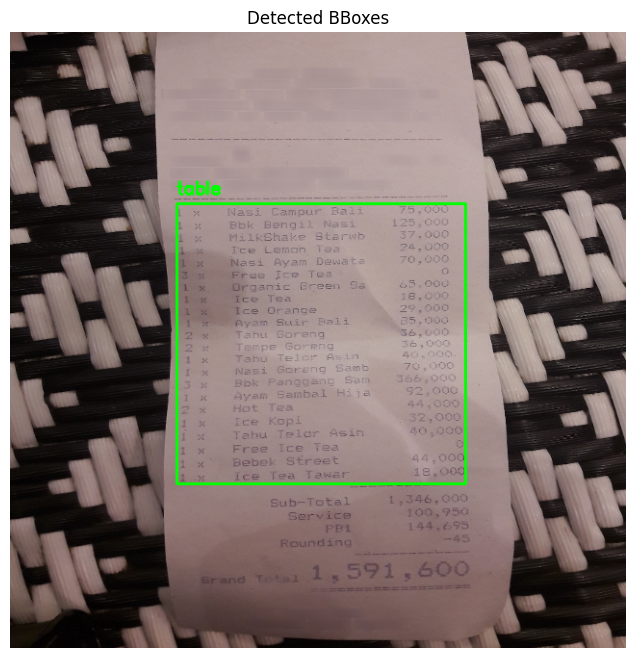


0: 640x640 1 table, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
nasi campur bali {uo bok bengil nas1 125 cjo miikshake 9281wh vuo @non joo nas1 ayam deware joo ice tea orgarie @ceen ovv 1c t2= ooo ice oranoe ooc ayam suir aal oou en goreng ooo enne a € qoo ' ,' !0 l 7e] (2 % 1aoo n:s1 gorenc yan  bok an-qa: - s2f 366 ooo ayeun 5an962! h2] 52 ooc ooo hot tea ~cp kopi ooo tahu telcr asin 40 oco fr2e ice tea bebck street 44 ooo 15 = 12c 2ls 18,qo 1 22
{'status': 'success', 'items': [{'item_name': 'b0k bengil nas', 'price': 1125}, {'item_name': 'nas', 'price': 1}, {'item_name': 'n:s', 'price': 1}, {'item_name': 'g0renc yan  b0k an-0a: - s2f', 'price': 366000}, {'item_name': 'fr2e ice tea bebck street 4400015 = 12c 2ls 18,001', 'price': 22}]}

--- Gambar ke-1 ---

0: 640x640 1 table, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.4ms postp

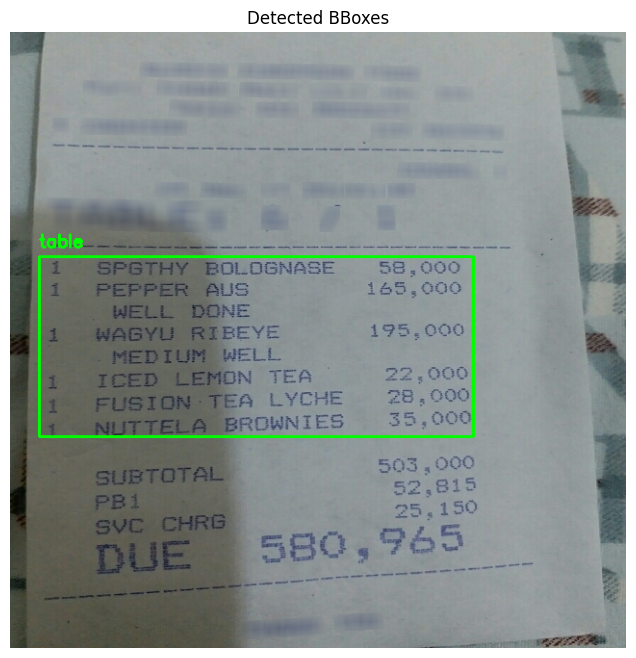


0: 640x640 1 table, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
spgthy bolognase 58 ooo pepper avs 165 ooo well done wagyv ribeye 195 ooo medium well iced lemon tea 22,ooo fusion tea lyche 28 , oqo nuttela brownies 35,ooo
{'status': 'success', 'items': [{'item_name': 'spgthy b0l0gnase', 'price': 58000}, {'item_name': 'pepper avs', 'price': 165000}, {'item_name': 'well d0ne wagyv ribeye', 'price': 195000}, {'item_name': 'medium well iced lem0n tea', 'price': 22000}, {'item_name': 'nuttela br0wnies', 'price': 35000}]}

--- Gambar ke-2 ---

0: 640x640 1 table, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


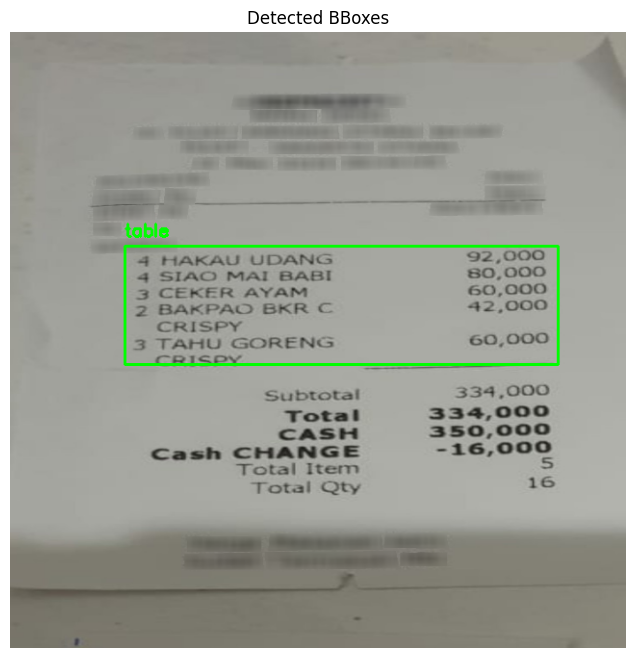


0: 640x640 1 table, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
hakau udang 92,000 slao mal 8a81 80 0oo ceker ayam 60,00o bakpao bkr 42,000 crispy tahu goreng 60,0oo 781so
{'status': 'success', 'items': [{'item_name': 'hakau udang', 'price': 92000}, {'item_name': 'mal 8a', 'price': 8180000}, {'item_name': 'ceker ayam', 'price': 60000}, {'item_name': 'bkr', 'price': 42000}]}

--- Gambar ke-3 ---

0: 640x640 1 table, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


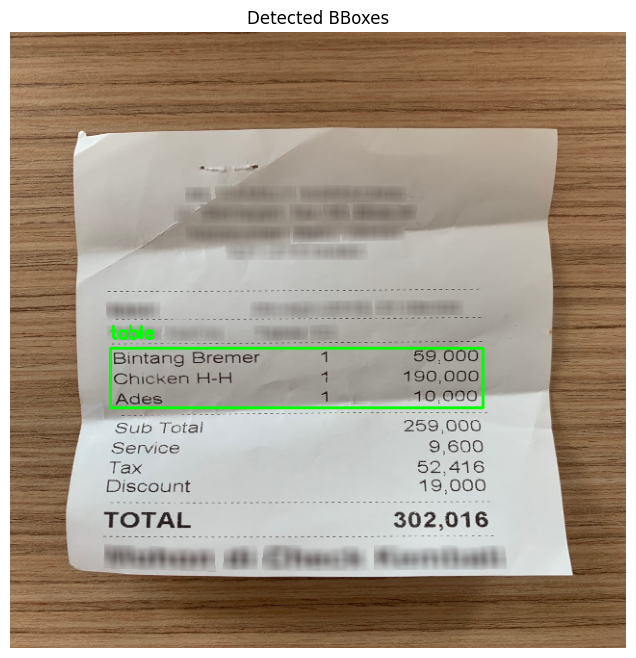


0: 640x640 1 table, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
bintang bremer 59,0oo chicken h-h 190,000 ades 10 0o0
{'status': 'success', 'items': [{'item_name': 'bintang bremer', 'price': 59000}, {'item_name': 'chicken h-h', 'price': 190000}, {'item_name': 'ades', 'price': 10000}]}

--- Gambar ke-4 ---

0: 640x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


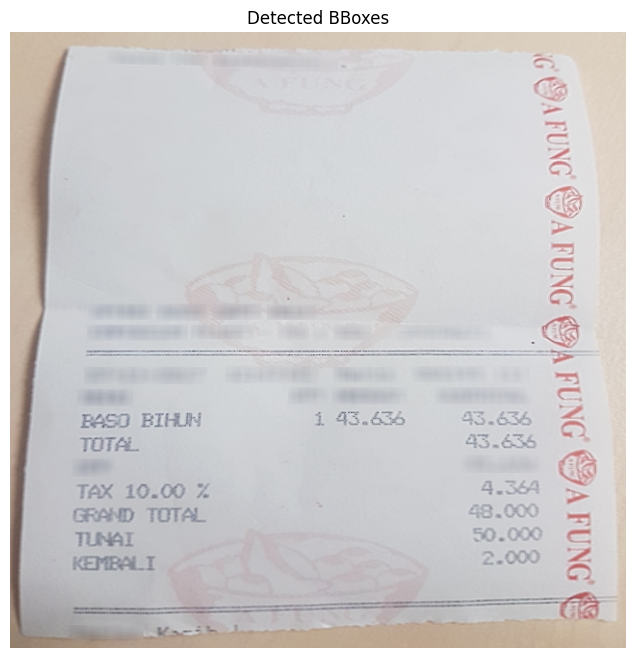


0: 640x640 (no detections), 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.
{'status': 'not_receipt_invoice', 'error_msg': 'Gambar yang Anda masukkan bukan receipt/invoice.'}


In [17]:
from datasets import load_dataset
import numpy as np

# Load dataset split
dataset = load_dataset("naver-clova-ix/cord-v2", split="test")

# # Loop untuk 5 gambar pertama
for i in range(5):
    print(f"\n--- Gambar ke-{i} ---")
    image_pil = dataset[i]['image']
    image_np = np.array(image_pil)

    # Proses model dan visualisasi
    boxes, classes = process_model(image_np)
    visualize_boxes_safe(image_np, boxes, classes, label_map)

    # Jalankan OCR dan ekstraksi hanya jika keyword ditemukan
    result = read_image(image_np)
    print(result)

In [15]:
# !pip install transformers torch

In [16]:
# from transformers import pipeline

# # Load model dan tokenizer dari Hugging Face
# model_name = "fitristachan/invoice-text-model"
# nlp_pipeline = pipeline("token-classification", model=model_name, tokenizer=model_name, aggregation_strategy="simple")

# def simulate_bert_classification(texts):
#     results = []
#     for text in texts:
#         predictions = nlp_pipeline(text)
#         for pred in predictions:
#             results.append({
#                 "class": pred["entity_group"].lower(),  # Misalnya: ITEM -> item_name
#                 "text": pred["word"]
#             })
#     return results
